In [115]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/quadrotor_traj_gen/Project.toml`


InterruptException: InterruptException:

In [116]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random
using JuMP
using COSMO
using OSQP
using Printf

In [204]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8705
└ @ MeshCat /home/khai/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


false

In [117]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [118]:
#Quadrotor parameters
m = 0.035
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
km = kt*thrustToTorque #4.4733e-8

freq1 = 50
h = 1/freq1 #50 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
nx = Nx̃
nu = Nu

4

In [119]:
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = [0; 0; -g] + (1/m)*Q*[zeros(2,4); kt*ones(1,4)]*u 

  ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [120]:
#Goal state
@show uhover = (m*g/kt/4)*ones(4)  # m = 30g and max thrust = 60g
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

uhover = (((m * g) / kt) / 4) * ones(4) = [0.5833333520642209, 0.5833333520642209, 0.5833333520642209, 0.5833333520642209]


In [121]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u 
end

discrete_dynamics (generic function with 1 method)

In [122]:
# Adaptive step in MPC horizon: use normal dt and model in the first specified 
# `adaptive_step` steps and after that use the stretch mode (larger dt and model)
freq2 = 10
h = 1/freq2 #25 Hz stretch interval dynamics
#Linearize dynamics about hover
As = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
Bs = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ãs = Array(E(qg)'*As*E(qg))
B̃s = Array(E(qg)'*Bs);
function discrete_dynamics_stretch(params,x,u,k)
  Ãs*x + B̃s*u
end


discrete_dynamics_stretch (generic function with 1 method)

In [123]:
h = 1/freq1 #50 Hz normal dynamics
step_ratio = Int(freq1/freq2)
# display(Ãs)
# display(Ã)

5

In [124]:
# IHLQR terminal cost
P = [zeros(nx,nx) for i = 1:200]   # cost to go quadratic term
p = [zeros(nx) for i = 1:200]      # cost to go linear term
d = [zeros(nu) for i = 1:200-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:200-1] # feedback gain

# Cost weights
# Saved
# max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.05;  0.5; 0.5; 0.5;  0.5; 0.5; 0.1]
# max_dev_u = [0.5; 0.5; 0.5; 0.5]/10
max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.03;  0.5; 0.5; 0.5;  0.7; 0.7; 0.2]
max_dev_u = [0.5; 0.5; 0.5; 0.5]
Q = diagm(1 ./(max_dev_x.^2))
R = diagm(1 ./(max_dev_u.^2))

# Q = Array(Diagonal([10; 10; 10; 1; 1; 1; 1; 1; 1; 1; 1; 1.]));
# R = Array(1*I(Nu));
Qf = 1*Q

# PENALTY - important!!
ρ = 250.0
R̃ = R + ρ*I  

display(Q)
display(R)

# Precompute
cache = (
    Kinf = zeros(nu,nx),
    Pinf = zeros(nx,nx),
    Kinf2 = zeros(nu,nx),
    Pinf2 = zeros(nx,nx),
    Quu_inv = zeros(nu,nu),
    Quu_inv2 = zeros(nu,nu),
    AmBKt = zeros(nx,nx), 
    AmBKt2 = zeros(nx,nx), #(Ã - B̃*K[1])',
    coeff_d2p = zeros(nx,nu), 
    coeff_d2p2 = zeros(nx,nu), 
)

P[200] .= Q
for k = (200-1):-1:1
    K[k] .= (R̃ + B̃s'*P[k+1]*B̃s)\(B̃s'*P[k+1]*Ãs)
    P[k] .= Q + Ãs'*P[k+1]*(Ãs - B̃s*K[k])
end
cache.Kinf2 .= K[1]  # correct, tested with dlqr
cache.Pinf2 .= P[1]
cache.AmBKt2 .= (Ãs - B̃s*K[1])'
for k = (200-1):-1:1
    K[k] .= (R̃ + B̃'*P[k+1]*B̃)\(B̃'*P[k+1]*Ã)
    P[k] .= Q + Ã'*P[k+1]*(Ã - B̃*K[k])
end
cache.Kinf .= K[1]
cache.Pinf .= P[1]
cache.AmBKt .= (Ã - B̃*K[1])'

cache.Quu_inv .= (R̃ + B̃'*cache.Pinf*B̃)\I
display(cond(cache.Quu_inv))
cache.Quu_inv2 .= (R̃ + B̃s'*cache.Pinf2*B̃s)\I

cache.coeff_d2p .= cache.Kinf'*R̃ - cache.AmBKt*cache.Pinf*B̃
cache.coeff_d2p2 .= cache.Kinf2'*R̃ - cache.AmBKt2*cache.Pinf2*B̃s;

12×12 Matrix{Float64}:
 100.0    0.0    0.0  0.0  0.0     0.0   …  0.0  0.0  0.0      0.0       0.0
   0.0  100.0    0.0  0.0  0.0     0.0      0.0  0.0  0.0      0.0       0.0
   0.0    0.0  100.0  0.0  0.0     0.0      0.0  0.0  0.0      0.0       0.0
   0.0    0.0    0.0  4.0  0.0     0.0      0.0  0.0  0.0      0.0       0.0
   0.0    0.0    0.0  0.0  4.0     0.0      0.0  0.0  0.0      0.0       0.0
   0.0    0.0    0.0  0.0  0.0  1111.11  …  0.0  0.0  0.0      0.0       0.0
   0.0    0.0    0.0  0.0  0.0     0.0      0.0  0.0  0.0      0.0       0.0
   0.0    0.0    0.0  0.0  0.0     0.0      4.0  0.0  0.0      0.0       0.0
   0.0    0.0    0.0  0.0  0.0     0.0      0.0  4.0  0.0      0.0       0.0
   0.0    0.0    0.0  0.0  0.0     0.0      0.0  0.0  2.04082  0.0       0.0
   0.0    0.0    0.0  0.0  0.0     0.0   …  0.0  0.0  0.0      2.04082   0.0
   0.0    0.0    0.0  0.0  0.0     0.0      0.0  0.0  0.0      0.0      25.0

4×4 Matrix{Float64}:
 4.0  0.0  0.0  0.0
 0.0  4.0  0.0  0.0
 0.0  0.0  4.0  0.0
 0.0  0.0  0.0  4.0

3.162605344926837

In [125]:
display(cache.Kinf)
# C Language for LQR2 alone
@printf("FOR C:\n");
str = "static float K[NU][NXt] = {\n"
for i = 1:4
  str = str * "  {"
  for j = 1:12
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", cache.Kinf[i, j])

    str = str * this_str * "f"
    if j < 12
      str = str * ","
    end
  end
  str = str * "},\n"
end
str = str * "};"
@printf("%s",str)

4×12 Matrix{Float64}:
 -0.185941   0.18197   0.303191  …  -0.0404101  -0.0512644  -0.288966
  0.179831   0.167486  0.303191     -0.0240501   0.0493227   0.289811
  0.165689  -0.173896  0.303191      0.02602     0.0152782  -0.291778
 -0.159579  -0.17556   0.303191      0.0384402  -0.0133366   0.290933

FOR C:
static float K[NU][NXt] = {
  {-0.185941f,0.181970f,0.303191f,-0.546725f,-0.608453f,-0.970142f,-0.111564f,0.106189f,0.199335f,-0.040410f,-0.051264f,-0.288966f},
  {0.179831f,0.167486f,0.303191f,-0.437358f,0.583703f,0.985421f,0.107392f,0.093663f,0.199335f,-0.024050f,0.049323f,0.289811f},
  {0.165689f,-0.173896f,0.303191f,0.462703f,0.398212f,-1.021815f,0.091017f,-0.097985f,0.199335f,0.026020f,0.015278f,-0.291778f},
  {-0.159579f,-0.175560f,0.303191f,0.521380f,-0.373462f,1.006536f,-0.086845f,-0.101867f,0.199335f,0.038440f,-0.013337f,0.290933f},
};

In [197]:
#Feedback tracking controller
include("tinyMPC.jl")
include("mpc_JuMP.jl")
dt = 1/freq1
Tfinal = 4.0 # final time
Nt = Int(Tfinal/dt)+1    # number of time steps
N = Nt
Nh = Nt
t_vec = h*(0:Nt-1)

#Create trajectory to follow
Xref = [[zeros(3); 1; zeros(9)] for i = 1:Nt]
Δx̃ref = [zeros(nx) for i = 1:Nt]
ΔUref = [zeros(nu) for i = 1:Nt-1]

## Hovering
# Xref = [xg for i = 1:Nt]

## Number-eight
# Xref = [[1*cos(t)*sin(t);1*cos(t);1;1;zeros(9)] for t = range(-pi/2, 3*pi/2, length = Nt)]  

## Triangle
# p0 = [0; 0; 1.0]; p1 = [3; 4; 1.]; p2 = [0; 8; 1.]; p3 = [0; 0; 1.0]
# range1 = collect(LinRange(p0, p1, round(Int,(Nt)/3)))
# range2 = collect(LinRange(p1, p2, round(Int,(Nt)/3)))
# range3 = collect(LinRange(p2, p3, round(Int,(Nt)/3)+1))
# range123 = [range1; range2; range3]
# for k = 1:Nt
#     Xref[k][1:3] .= range123[k]
# end

# Square
# p0 = [0; 0; 1]; p1 = [2; 0; 1]; p2 = [2; 2; 1]; p3 = [0; 2; 1]
# range1 = collect(LinRange(p0, p1, round(Int,(Nt)/4)))
# range2 = collect(LinRange(p1, p2, round(Int,(Nt)/4)))
# range3 = collect(LinRange(p2, p3, round(Int,(Nt)/4)))
# range4 = collect(LinRange(p3, p0, round(Int,(Nt)/4)+1))
# range1234 = [range1; range2; range3; range4]
# for k = 1:Nt
#     Xref[k][1:3] .= range1234[k]
# end

# Velocity reference: speeds up the tracking but less smooth
for i = 1:Nt-1
    Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
end
for k = 1:Nt
    x = Xref[k]
    q = x[4:7]
    ϕ = qtorp(L(qg)'*q)   
    Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
end  

optimizer = JuMP.optimizer_with_attributes(OSQP.Optimizer,
        "verbose"=>false,
        "eps_abs"=>1e-4,
        "eps_rel"=>1e-4,
        "eps_prim_inf"=>1e-4,
        "eps_dual_inf"=>1e-4,
        "max_iter"=>1000)
        # "rho"=>1e-2,
        # "scaling"=>0,
        # "alpha"=>1.0,)  

model = Model(optimizer)

u_min = -uhover
u_max =  [1; 1; 1; 1] - uhover

# state is x y v θ
x_min = -100*ones(nx)
x_min[3] = -0.2
x_max = 100*ones(nx)
x_max[3] = 0.2

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
X[1][3] = 1
U = [zeros(nu) for k = 1:N-1]
Z = [zeros(nu) for i = 1:N-1]
Znew = [zeros(nu) for i = 1:N-1]
Y = [zeros(nu) for i = 1:N-1]

params = (
    nx = nx, nu = nu, ncx = 0, ncu = 1, ncg = 0, ncu_cone = 0,
    N = N, Q = Q, R = R, Qf = Qf,
    u_min = u_min, u_max = u_max,
    x_min = x_min, x_max = x_max,
    Xref = Δx̃ref, Uref = ΔUref, dt = dt, cache = cache
);

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
qq = [zeros(nx) for i = 1:N]
r = [zeros(nu) for i = 1:N-1]

u = mpc_JuMP!(optimizer, params, X, U, Ã, B̃, 0.0; warm_start=true)

  0.022829 seconds (113.26 k allocations: 13.231 MiB)


┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{OSQP.MathOptInterfaceOSQP.Optimizer, MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.GenericModel{Float64, MathOptInterface.Utilities.ModelFunctionConstraints{Float64}}}}}. This information will be discarded.
└ @ MathOptInterface.Utilities /home/khai/.julia/packages/MathOptInterface/YDdD3/src/Utilities/copy.jl:290


4-element Vector{Float64}:
 -0.5833303706385874
  0.4166637867040267
  0.10653698364442063
 -0.15323878680535774

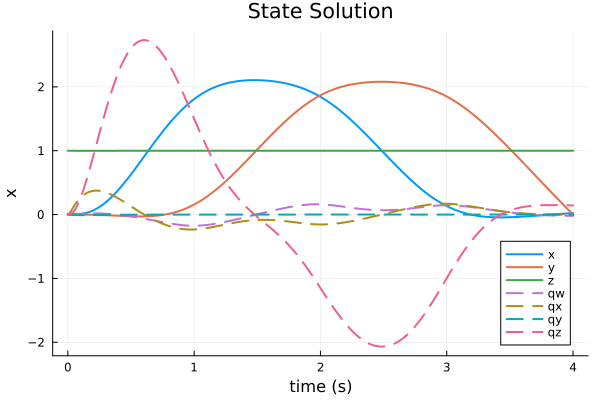

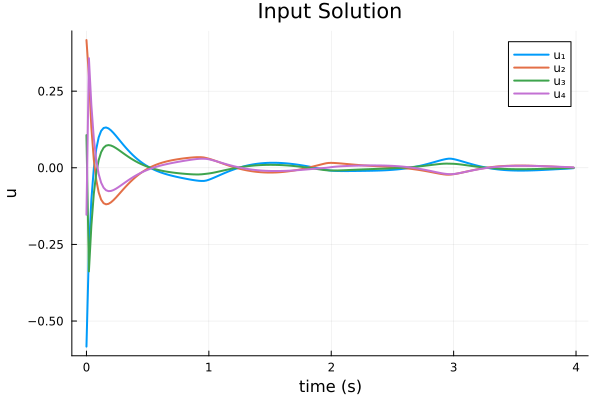

In [198]:
# Plots
Xsim_m = mat_from_vec(X)
Usim_m = mat_from_vec(U)
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input Solution", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

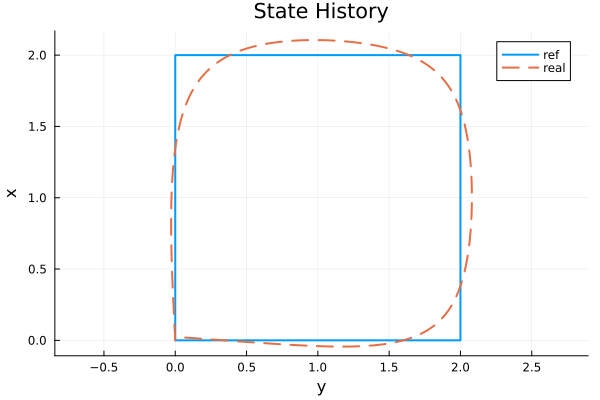

In [199]:
Xsim_m = mat_from_vec(Xref[1:N])
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(X[1:N])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

In [205]:
X1 = [zeros(13) for i = 1:Nt]
for k = 1:Nt
  x = 1*X[k]
  ϕ = 1*x[4:6]
  qq = 1*rptoq(ϕ)
  X1[k] .= [x[1:3]+rg; qq; x[7:9]+vg; x[10:12]+ωg]
end  
X2 = [SVector{13}(x) for x in X1];
visualize!(vis, model, t_vec[end], X2)

In [203]:
X_ref_data = [X[i][1:12] for i = 1:Nt]
# Export a vector of vectors to C header and source 
function export_vec_to_c(filename, var_type, var_name, data)
  declare = var_type * " " * var_name
  def = declare * " = {\n"
  for i=1:length(data)
      def = def * "  "
      for j=1:length(data[1])
        #   def = def * string(data[i][j])
          def = def * @sprintf("%.4f", data[i][j])
          if j < length(data[1]) 
              def = def * ","
          end
      end
      if i < length(data)
          def = def * ",\n"
      end
  end
  def = def*"}"

  open(filename*".h","a") do io
          println(io, def * ";\n")
  end
  return true
end
export_vec_to_c("data", "static sfloat", "X_ref_data[]", X_ref_data)

true